In [2]:
# Useful starting lines
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=True)

In [11]:
#from helpers import *
def load_data():
    """load data."""
    data = np.loadtxt("dataEx4.csv", delimiter=",", skiprows=1, unpack=True)
    #a = pd.read_csv("height_weight_genders.csv",sep=",")
    #data = a.drop(a.columns[0], axis=1).values.T
    x = data[0]
    y = data[1]
    return x, y

def standardise(x):
    """Standardise the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x

def split_data(x, y, ratio, myseed=1):
    """split the dataset based on the split ratio."""
    # set seed
    #np.random.seed(myseed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te


def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

index=0, proportion=0.2, degree=3, lambda=0.00001, Training RMSE=0.3154, Testing RMSE=0.3195
index=1, proportion=0.2, degree=3, lambda=0.00001, Training RMSE=0.3202, Testing RMSE=0.3158
index=2, proportion=0.2, degree=3, lambda=0.00002, Training RMSE=0.2784, Testing RMSE=0.2988
index=3, proportion=0.2, degree=3, lambda=0.00003, Training RMSE=0.2825, Testing RMSE=0.3109
index=4, proportion=0.2, degree=3, lambda=0.00005, Training RMSE=0.2950, Testing RMSE=0.2997
index=5, proportion=0.2, degree=3, lambda=0.00007, Training RMSE=0.2862, Testing RMSE=0.2866
index=6, proportion=0.2, degree=3, lambda=0.00011, Training RMSE=0.3337, Testing RMSE=0.2859
index=7, proportion=0.2, degree=3, lambda=0.00016, Training RMSE=0.3122, Testing RMSE=0.2914
index=8, proportion=0.2, degree=3, lambda=0.00024, Training RMSE=0.2838, Testing RMSE=0.2933
index=9, proportion=0.2, degree=3, lambda=0.00036, Training RMSE=0.2839, Testing RMSE=0.3182
index=10, proportion=0.2, degree=3, lambda=0.00053, Training RMSE=0.28

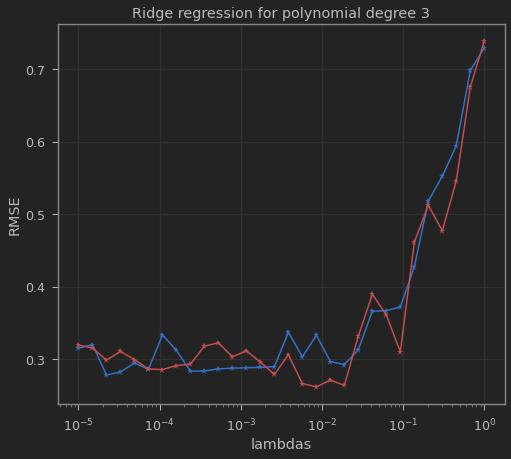

In [10]:
def get_grad_ridge(tx, y, w, lamb):
    err = y - tx.dot(w)
    grad = -err.dot(tx)/ len(err) + lamb*w
    return grad, err

def mse_ridge(e, lamb, w):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)+1/2*lamb*w.dot(w) 

def compute_mse(y, tx, w):
    """compute the loss by mse."""
    err = y - tx.dot(w)
    return 1/2*np.mean(err**2)

def ridge_reg_SGD(y, X, d, max_iters, gamma, lamb, batch_size):
    tx = build_poly(X, d)
    initial_w = np.zeros(d+1)
    w = initial_w
    ws = [initial_w]
    losses = []
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1, shuffle=True):
            # compute loss, gradient
            #err = y - tx.dot(w)
            #grad = (-err.dot(tx)/ len(err) + lamb*w) 
            #loss = 1/2*np.mean(err**2) + lamb*np.dot(w,w)
            grad, err = get_grad_ridge(tx_batch, y_batch, w, lamb)
            loss = mse_ridge(err, lamb, w)
            w = w - gamma * grad
            ws.append(w)
            losses.append(loss)
    #         if n_iter % 100 == 0:
    #             print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
    #                 bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return w, tx

x, y = load_data()
x, mean_x, std_x = standardise(x)
d = 3
max_iters = 2000
gamma = 0.08
seed = 56
split_ratio = 0.2
batch_size = 2

def ridge_reg_SGD_demo(x, y, split_ratio, seed, d, max_iters, gamma):
    
    x_tr, x_te, y_tr, y_te = split_data(x, y, split_ratio, seed)
    built_x_te = build_poly(x_te, d)
    lambdas = np.logspace(-5, 0, 30)
    rmse_tr = []
    rmse_te = []
    rmse_te_dict = {}
    weights = []
    for ind, lamb in enumerate(lambdas):
        weight, built_x_tr = ridge_reg_SGD(y_tr, x_tr, d, max_iters, gamma, lamb, batch_size)
        weights.append(weight)
        rmse_tr.append(np.sqrt(2*compute_mse(y_tr, built_x_tr, weight)))
        rmse_te.append(np.sqrt(2*compute_mse(y_te, built_x_te, weight)))
        rmse_te_dict[ind] = np.sqrt(2*compute_mse(y_te, built_x_te, weight))
        print("index={ind}, proportion={p}, degree={d}, lambda={l:.5f}, Training RMSE={tr:.4f}, Testing RMSE={te:.4f}".format(
            ind=ind, p=split_ratio, d=d, l=lamb, tr=rmse_tr[ind], te=rmse_te[ind]))
    plt.semilogx(lambdas, rmse_tr, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, list(rmse_te_dict.values()), color='r', marker='*', label="Test error")
    plt.xlabel("lambdas")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(d))
    
    min_err_index = min(rmse_te_dict, key=rmse_te_dict.get)
    
    return rmse_te_dict, lambdas[min_err_index], weights[min_err_index], built_x_te, y_te
    
rmses, best_lambda, weights, x_test, y_test = ridge_reg_SGD_demo(x, y, split_ratio, seed, d, max_iters, gamma)

In [494]:
min(list(rmses.values()))

0.2747190426701881

In [495]:
weights

array([-0.15635875, -1.31785381,  0.08478499,  0.46841826])

In [496]:
np.sqrt(1/len(y_test)*np.sum((x_test.dot(weights[:, None])-y_test[:, None])**2))

0.2747190426701881

### Sklearn

In [509]:
x, y = load_data()
x_tr, x_te, y_tr, y_te = split_data(x, y, split_ratio, seed)
built_x_tr = build_poly(x_tr, 3)
built_x_te = build_poly(x_te, 3)

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('Ridge', Ridge(alpha=0.01))])
#linr = pipe(alpha=best_lambda)
pipeline.fit(built_x_tr, y_tr[:, None])
print(' a and b by scikit-learn')
#print(linr.intercept_, linr.coef_[0])
pipeline.named_steps['Ridge'].coef_

 a and b by scikit-learn


array([[ 0.        ,  1.14969137, -4.87369005,  3.71278277]])

In [510]:
from sklearn.metrics import mean_squared_error
y_pred = pipeline.predict(built_x_te)
rms = mean_squared_error(y_te, y_pred, squared=False)
rms

0.374809231962461

In [397]:
x_test.shape

(40, 4)